In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.


import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

import numpy as np
import tensorflow as tf
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *

In [12]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='LSTMClassification'

predict_n = 5

In [13]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

0          7.393333
1          7.440000
2          7.346667
3          7.353333
4          7.360000
            ...    
14826    124.690002
14827    124.820000
14828    123.800003
14829    124.339996
14830    125.879997
Name: Close, Length: 14831, dtype: float64


,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.613174,0.394439,0.575048,0.643619,higher,0.015051,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.611388,0.394997,0.572212,0.611458,lower,0.015177,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.612154,0.395653,0.575703,0.651147,higher,0.015162,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.612167,0.396346,0.574721,0.639898,lower,0.014516,lower
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.609286,0.397285,0.570357,0.590036,lower,0.014705,higher


In [14]:
df = data_wrapper.df
feature_names = data_wrapper.feature_names

In [29]:
y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names
data_columns = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']
data_columns += [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
y = dataset[y_column]

X.head(), y.head()

(      Close    Volume  MACD_diff   RSI(14)  PercentageDiff    LowLen  RSI_diff
 0  0.015429  0.003780   0.546478  0.595025        0.643619  0.002525  0.483363
 1  0.015051  0.003456   0.545495  0.456905        0.611458  0.000000  0.269859
 2  0.015177  0.002700   0.545121  0.505305        0.651147  0.000000  0.535921
 3  0.015162  0.001944   0.544865  0.499957        0.639898  0.001263  0.459252
 4  0.014516  0.005076   0.543437  0.332912        0.590036  0.000842  0.228598,
 0    0
 1    1
 2    0
 3    0
 4    1
 Name: Next, dtype: int64)

In [42]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_test = X_test.sort_index()
y_test = y_test.sort_index()


print(f"Train size : {len(X_train)}, test_size : {len(X_test)}")

ValueError: Found input variables with inconsistent numbers of samples: [14797, 20]

In [20]:
seq_len=5

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=seq_len,
    batch_size=32,
)


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=5,
    batch_size=32,
)


In [45]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"Inputs : {inputs[:1]}, targets : {targets[:1]}")
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Inputs : [[[0.06503873 0.00538558 0.53976795 0.57289458 0.65843388 0.
   0.49826814]
  [0.10618978 0.03020533 0.56823956 0.56790702 0.61887628 0.
   0.4099935 ]
  [0.91479309 0.05517628 0.43594848 0.40687764 0.66730771 0.17045345
   0.58573455]
  [0.55046759 0.174608   0.78979181 0.75393734 0.76828346 0.03945708
   0.59190834]
  [0.05848526 0.00927357 0.532866   0.29282192 0.63700987 0.00157816
   0.46032184]]], targets : [0]
Input shape: (32, 5, 7)
Target shape: (32,)


In [79]:
from tensorflow.keras import layers

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(100)(inputs)
dropout = keras.layers.Dropout(0.2)(lstm_out)
dense_2 = keras.layers.Dense(100)(dropout)
dropout_2 = keras.layers.Dropout(0.2)(dense_2)
outputs = keras.layers.Dense(1, activation='sigmoid')(dropout_2)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               43200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 53,401
Trainable params: 53,401
Non-trainable params: 0
______________________________________________________

In [80]:
history = model.fit(
    train_dataset,
    epochs=20,
    #validation_data=val_dataset,
)

Epoch 1/20
324/324 [==============================] - 3s 4ms/step - loss: 0.6957 - accuracy: 0.5005
Epoch 2/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6943 - accuracy: 0.4995
Epoch 3/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.5061
Epoch 4/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.5078
Epoch 5/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.5089
Epoch 6/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6937 - accuracy: 0.5057
Epoch 7/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.5079
Epoch 8/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.5088
Epoch 9/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5129
Epoch 10/20
324/324 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5091

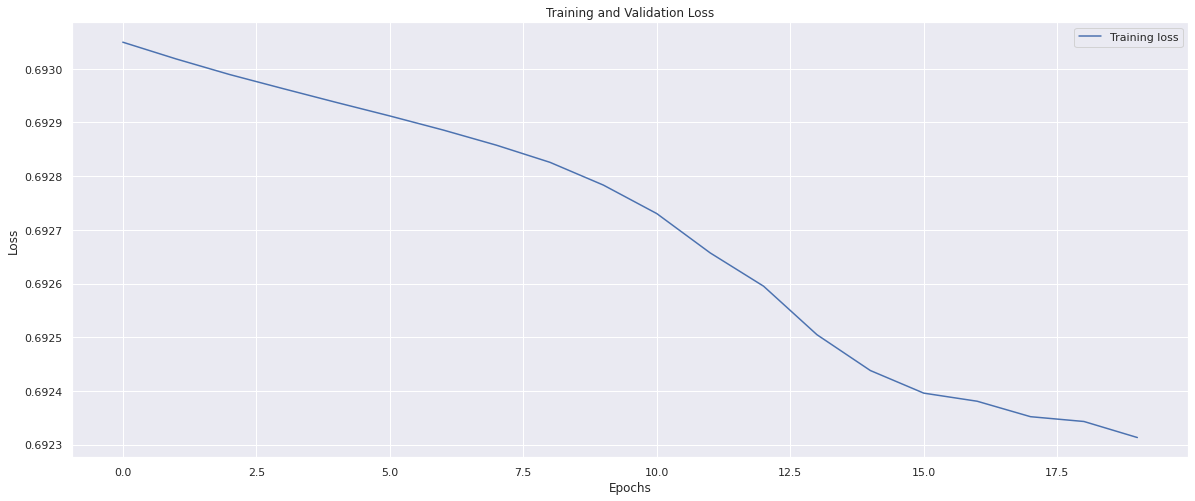

In [47]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [49]:
# Final evaluation of the model
scores = model.evaluate(val_dataset, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 50.83%


In [50]:
predictions = np.array([])
labels = np.array([])

for x, y in tqdm(val_dataset):
    predictions = np.concatenate([predictions, model.predict(x).flatten()])
    labels = np.concatenate([labels,y])

  0%|          | 0/139 [00:00<?, ?it/s]

In [51]:
print(predictions)

[0.48654196 0.48688644 0.4872115  ... 0.49374908 0.49533448 0.49261612]


In [52]:
test_df = pd.DataFrame(data={'Close':predictions})
scaled_preds = data_wrapper.get_unscaled_data(df=test_df)['Close']
test_df = pd.DataFrame(data={'Close':labels})
scaled_labels = data_wrapper.get_unscaled_data(df=test_df)['Close']

In [53]:
print(scaled_preds)
print(scaled_labels)

0       107.090665
1       107.163599
2       107.232419
3       106.113587
4       106.815370
           ...    
4431    108.564975
4432    108.259571
4433    108.616557
4434    108.952217
4435    108.376686
Name: Close, Length: 4436, dtype: float64
0         4.080000
1         4.080000
2         4.080000
3         4.080000
4         4.080000
           ...    
4431    215.800003
4432      4.080000
4433    215.800003
4434      4.080000
4435      4.080000
Name: Close, Length: 4436, dtype: float64


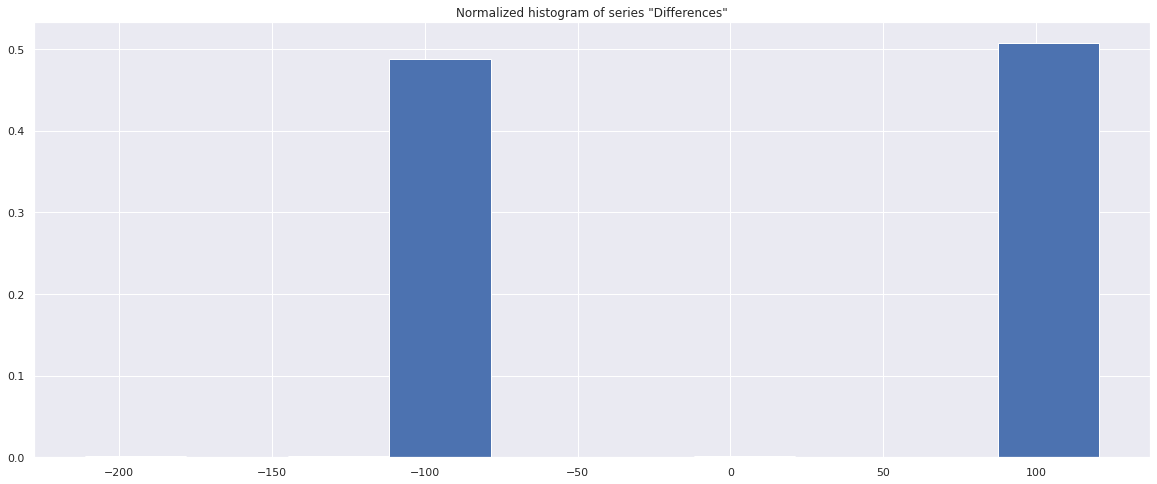

In [54]:
plot_normalized_histogram(series=pd.Series([p - y for p,y in zip(scaled_preds, scaled_labels)], name="Differences"))
plt.show()

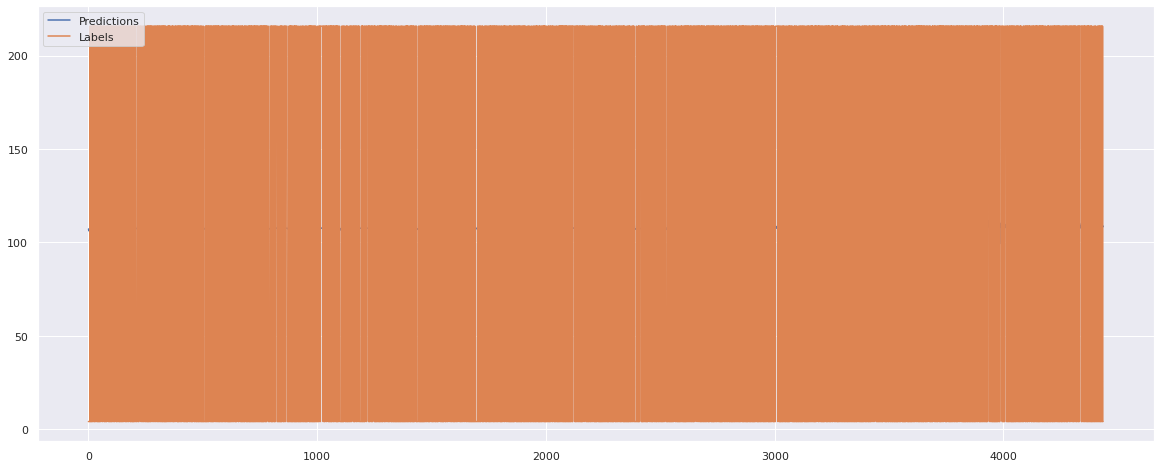

In [55]:
ax = plt.gca()
ax.plot(scaled_preds, label="Predictions")
ax.plot(scaled_labels, label="Labels")
plt.legend(loc='best')
plt.show()